In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import trompy as tp
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
%matplotlib inline

In [2]:
with open('C://Data//hislight_pickles//adlib_sucralose.pickle', 'rb') as handle:
    adlib_sucralose = pickle.load(handle)    
    
with open('C://Data//hislight_pickles//adlib_dark.pickle', 'rb') as handle:
    adlib_dark = pickle.load(handle)

In [3]:
list_of_mice = []

for key, val in adlib_dark.items():
    if val["mouse_ID"] not in list_of_mice:
        list_of_mice.append(val["mouse_ID"])

In [14]:
def get_snips(data):

    snips_mean_start= []
    snips_mean_end = []
    snips_mean_full = []

    kwargs={"bins":150, "trial_length":15, "baseline_length":5}   

    pre = 5
    post = 10
    mineventlength=10
    binlength=0.1

    for mouse in list_of_mice:
        snips_start = []
        snips_end = []
        snips_full = []

        for key, val in data.items():
            if val["mouse_ID"]==mouse:
                if len(val["licks"]) < 10:
                    continue

                lickdata= tp.lickCalc(val["licks"], minrunlength=3)

                snips_start.append(tp.snipper(val["corrected"], lickdata["rStart"], val["fs"], **kwargs)[0])
                snips_end.append(tp.snipper(val["corrected"], lickdata["rEnd"], val["fs"], **kwargs)[0])

                snipper = tp.Snipper(val["corrected"],
                                        lickdata["rStart"],
                                        end=lickdata["rEnd"],
                                        fs=val["fs"],
                                        pre=pre,
                                        post=post,
                                        binlength=binlength,
                                        zscore=True
                                        )

                snipper.truncate_to_same_length(cols_to_add=10, mineventlength=mineventlength)
                snipper.find_potential_artifacts(threshold=8, method="sum")
                snips_full.append(snipper.snips)


        snips_start = np.vstack(snips_start)
        snips_end = np.vstack(snips_end)
        
        try:
            snips_full = np.vstack(snips_full)
            snips_mean_full.append(np.mean(snips_full, axis=0))
            print("adding this mouse")
        except:
            print("no snips to concatenate")

        snips_mean_start.append(np.mean(snips_start, axis=0))
        snips_mean_end.append(np.mean(snips_end, axis=0))
   
    snips_mean_full = np.array(snips_mean_full)
    
    return snips_mean_start, snips_mean_end, snips_mean_full

In [15]:
def get_runs(onset, min_run_length=3, run_threshold=10):

    current_list = []
    runs = []
    
    for i in range(1, len(onset)):
        time_diff = (onset[i] - onset[i - 1])
        if time_diff <= run_threshold:
            current_list.append(onset[i])
        else:
            current_list = [onset[i]]
            runs.append(current_list)
            
    no_short_runs = []
    
    for run in runs:
        if len(run)>min_run_length-1:
            no_short_runs.append(run)
     
    time_zeroed_runs = []
    
    for run in no_short_runs:
        time_zeroed_runs.append([t-run[0] for t in run])

    return time_zeroed_runs


def get_runs_from_all (data, mice):
    #print(data)

    temp_runs = []
    
    for mouse in mice:
        for key, val in data.items():
            #print(val)
            onset = val["licks"]
            temp_runs.append(get_runs(onset))

    all_runs = []
    for session in temp_runs:
        for run in session:
            all_runs.append(run)
            
    return all_runs


def sort_runs(runs):
    sort_order = np.argsort([x[-1]for x in runs])
    runs_sorted = [runs[i] for i in sort_order]
    
    return runs_sorted 

def make_data_for_lick_raster(runs):
    data= tp.flatten_list(runs)
    ymin= []
    ymax= []
    for idx,run in enumerate(runs):
        ymin.append([idx]*len(run))
    
    ymin=np.array(tp.flatten_list(ymin))
    ymax=ymin+0.9

    return data, ymin, ymax

In [16]:
#getting snips
sucralose_start, sucralose_end, sucralose_full = get_snips(adlib_sucralose)
dark_start, dark_end, dark_full = get_snips(adlib_dark)

<class 'numpy.ndarray'>
adding this mouse
<class 'numpy.ndarray'>
Found 1 potential artifacts.
<class 'numpy.ndarray'>
Found 1 potential artifacts.
adding this mouse
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
adding this mouse
<class 'numpy.ndarray'>
Found 5 potential artifacts.
<class 'numpy.ndarray'>
Found 1 potential artifacts.

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:186: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)



no snips to concatenate
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Found 1 potential artifacts.
adding this mouse
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Found 1 potential artifacts.
no snips to concatenate
<class 'numpy.ndarray'>
Found 2 potential artifacts.
<class 'numpy.ndarray'>
adding this mouse
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
adding this mouse
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
adding this mouse
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
adding this mouse
<class 'numpy.ndarray'>
Found 1 potential artifacts.
<class 'numpy.ndarray'>
Found 1 potential artifacts.
adding this mouse


C:\Users\kvo019\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kvo019\Anaconda3\lib\site-packages\numpy\core\_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-14-32b8be22d27c>:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  snips_mean_full = np.array(snips_mean_full)


<class 'numpy.ndarray'>
Found 6 potential artifacts.
<class 'numpy.ndarray'>
no snips to concatenate
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
adding this mouse
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
adding this mouse
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Found 1 potential artifacts.
adding this mouse
<class 'numpy.ndarray'>
Found 6 potential artifacts.
<class 'numpy.ndarray'>
Found 3 potential artifacts.
no snips to concatenate
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
adding this mouse
<class 'numpy.ndarray'>
Found 5 potential artifacts.
<class 'numpy.ndarray'>
Found 1 potential artifacts.
adding this mouse
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
adding this mouse
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
adding this mouse
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
adding this mouse
<class 'numpy.ndarray'>
Found 1 potential artifacts.
<class 'numpy.ndarray'>
Found 1 potential artifacts.
adding this mouse


In [17]:
#getting behavior
sucralose_runs = get_runs_from_all(adlib_sucralose, list_of_mice)
adlib_dark_runs = get_runs_from_all(adlib_dark, list_of_mice)

bins= np.arange(-5,40,1)

sucralose_hist = np.histogram(tp.flatten_list(sucralose_runs), bins= bins)
adlib_dark_hist = np.histogram(tp.flatten_list(adlib_dark_runs), bins= bins)

sucralose_sorted_runs = sort_runs(sucralose_runs)
adlib_dark_sorted_runs = sort_runs(adlib_dark_runs)

data_sucralose, ymin_sucralose, ymax_sucralose =make_data_for_lick_raster(sucralose_sorted_runs)
data_adlib_dark, ymin_adlib_dark, ymax_adlib_dark =make_data_for_lick_raster(adlib_dark_sorted_runs)

In [18]:
colors_sucralose = "#E9B824"
colors_adlib_dark = "#EE9322"

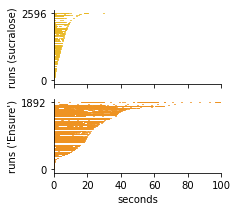

In [19]:
f,ax = plt.subplots(figsize=(3, 3),nrows=2, sharex = True)
#plt.subplots_adjust(hspace=0.8)


ax[0].vlines(data_sucralose, ymin_sucralose, ymax_sucralose, color= colors_sucralose)
ax[1].vlines(data_adlib_dark, ymin_adlib_dark, ymax_adlib_dark, color= colors_adlib_dark)    


#ax[0].set_title("adlib light")
#ax[1].set_title("adlib dark")

ax[0].set_ylabel("runs (sucralose)")
ax[1].set_ylabel("runs ('Ensure')")

ax[0].set_yticks([0, len(sucralose_sorted_runs)])
ax[1].set_yticks([0,len(adlib_dark_sorted_runs)])

ax[0].set_xlim(0,100)

ax[1].set_xlabel("seconds")

for ax in [ax[0],ax[1]]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

IndexError: tuple index out of range

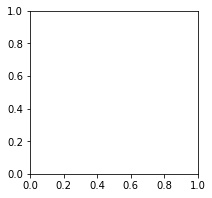

In [20]:
f, ax =plt.subplots(figsize=[3,3])

pre = 5
post = 10
mineventlength=10
binlength=0.1

bins_early = int((pre + mineventlength/2)/binlength)
bins_late = int((post + mineventlength/2)/binlength)

# sucralose

x1_sucralose = np.arange(0,bins_early)
x2_sucralose = np.arange(sucralose_full.shape[1] - bins_late, sucralose_full.shape[1])

mean_sucralose = np.nanmean(sucralose_full, axis=0)
error_values_sucralose= np.std(sucralose_full, axis=0) / np.sqrt(len(sucralose_full))

ax.plot(x1_sucralose, mean_sucralose[:bins_early], color=colors_sucralose)
ax.plot(x2_sucralose, mean_sucralose[-bins_late:], color=colors_sucralose)

ax.fill_between(x1_sucralose, mean_sucralose[:bins_early]-error_values_sucralose[:bins_early], 
                mean_sucralose[:bins_early]+error_values_sucralose[:bins_early], 
                color=colors_sucralose, alpha=0.3)
ax.fill_between(x2_sucralose, mean_sucralose[-bins_late:]-error_values_sucralose[-bins_late:], 
                mean_sucralose[-bins_late:]+error_values_sucralose[-bins_late:], 
                color=colors_sucralose, alpha=0.3)

# adlib dark

x1_dark = np.arange(0,bins_early)
x2_dark = np.arange(dark_full.shape[1] - bins_late, dark_full.shape[1])

mean_dark = np.mean(dark_full, axis=0)
error_values_dark = np.std(dark_full, axis=0) / np.sqrt(len(dark_full))

ax.plot(x1_dark, mean_dark[:bins_early], color=colors_adlib_dark)
ax.plot(x2_dark, mean_dark[-bins_late:], color=colors_adlib_dark)

ax.fill_between(x1_dark, mean_dark[:bins_early]-error_values_dark[:bins_early], 
                mean_dark[:bins_early]+error_values_dark[:bins_early], 
                color=colors_adlib_dark, alpha=0.3)
ax.fill_between(x2_dark, mean_dark[-bins_late:]-error_values_dark[-bins_late:], 
                mean_dark[-bins_late:]+error_values_dark[-bins_late:], 
                color=colors_adlib_dark, alpha=0.3)

for spine in ["top", "right", "left", "bottom"]:
    ax.spines[spine].set_visible(False)

ax.set_yticks([])
ax.set_xticks([])

ax.plot([200,250], [-1,-1], linewidth=2, color="k")
ax.text(225,-1.1,"5 s", va="top", ha="center")

ax.plot([0,0], [0.5, 1.5], linewidth=2, color="k")
ax.text(-3, 1, "1 Z", va="center", ha="right")

ax.axvline(50, color="k", linestyle="--", alpha=0.5)
ax.axvline(160, color="k", linestyle="--", alpha=0.5)
